In [ ]:
!pip install langchain langgraph tiktoken faiss-cpu sentence-transformers langchain_community langchain_groq chromadb langchain_tavily

In [1]:
import os
from google.colab import userdata
GROQ_API_KEY = userdata.get('GROQ_API_KEY')
os.environ['GROQ_API_KEY'] = GROQ_API_KEY

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from langchain.document_loaders import TextLoader
import os, glob
from langchain_core.documents import Document

all_text = ""
for file_path in glob.glob("Curie_Radiation_Documents/*.txt"):
    loader = TextLoader(file_path)
    docs = loader.load()
    for doc in docs:
        all_text += doc.page_content + "\n"

# Create a single Document object
combined_doc = Document(page_content=all_text)

docs = [combined_doc]
len(docs)

1

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = splitter.split_documents(docs)

In [9]:
len(chunks)

20

In [10]:
from langchain.embeddings import HuggingFaceEmbeddings
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [11]:
from langchain.vectorstores import Chroma

vectorstore = Chroma.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [12]:
retriever.get_relevant_documents("What is the Curie radiation?")

/tmp/ipython-input-7707427.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retriever.get_relevant_documents("What is the Curie radiation?")


[Document(metadata={}, page_content='Techniques like PET scans and CT imaging rely on radioactive tracers.\nRadiation is also used to sterilize medical equipment and food products.\nIn cancer therapy, radiation is finely targeted with computer-assisted precision.\nCurie’s discoveries helped usher in the nuclear age and atomic research.\nSafety protocols now ensure minimal risk during radiation exposure.\nThe principles of radiation detection and shielding stem from early Curie experiments.'),
 Document(metadata={}, page_content='Their discoveries laid the foundation for nuclear physics and modern atomic theory.\nRadium, in particular, emitted powerful radiation, which intrigued scientists globally.\nTheir work marked the beginning of a new era in physical science.\nMarie Curie coined the term "radioactivity" to describe this phenomenon.\nCurie’s discoveries redefined the field of chemistry.\nShe proved that atoms could emit energy, transforming the atomic model.'),
 Document(metadata={

In [13]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

llm = ChatGroq(model='llama-3.1-8b-instant',
                temperature=0,
                max_tokens=None,
                timeout=None,
                max_retries=2,)

In [14]:
router_prompt = ChatPromptTemplate.from_messages([
    ("system", "Classify the query as one of the following:\n- RETRIEVE: Use knowledge from files.\n- GENERATE: General world knowledge.\nReturn only the label."),
    ("human", "{query}")
])

router_chain = router_prompt | llm | (lambda x: {"destination": x.content.strip().upper()})

In [15]:
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage

rag_prompt = ChatPromptTemplate.from_messages([
    ("system", "Use the context to answer the question."),
    ("human", "Context:\n{context}\n\nQuestion: {query}")
])
rag_chain = rag_prompt | llm | StrOutputParser()

gen_prompt = ChatPromptTemplate.from_messages([
    ("system", "Answer this general question."),
    ("human", "{query}")
])
gen_chain = gen_prompt | llm | StrOutputParser()

In [16]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableConfig

class State(TypedDict):
    query: str
    destination: str
    context: str
    answer: str

In [17]:
def do_route(state: State):
    out = router_chain.invoke({"query": state["query"]})
    return {"destination": out["destination"]}

def do_retrieve(state: State):
    docs = retriever.get_relevant_documents(state["query"])
    context = "\n---\n".join([doc.page_content for doc in docs])
    return {"context": context}

def do_rag(state: State):
    return {"answer": rag_chain.invoke({"query": state["query"], "context": state["context"]})}

def do_gen(state: State):
    return {"answer": gen_chain.invoke({"query": state["query"]})}

In [18]:
graph = StateGraph(State)

graph.add_node("route", do_route)
graph.add_node("retrieve", do_retrieve)
graph.add_node("rag", do_rag)
graph.add_node("generate", do_gen)

graph.add_conditional_edges(
    "route",
    lambda state: state["destination"],
    {
        "RETRIEVE": "retrieve",
        "GENERATE": "generate"
    }
)

graph.add_edge("retrieve", "rag")
graph.add_edge("rag", END)
graph.add_edge("generate", END)

graph.set_entry_point("route")

builder = graph.compile()

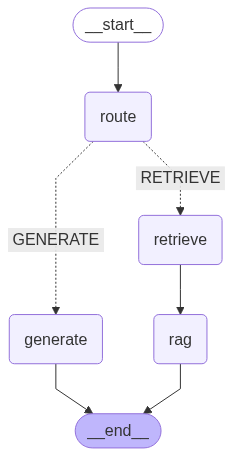

In [19]:
builder

In [27]:
res = builder.invoke({"query": "Who is Marie Curie and What She Did and Why did She get Nobel Price for?"})
"Answer:", res["answer"]

('Answer:',
 "Marie Curie (1867-1934) was a Polish-born physicist and chemist who made groundbreaking contributions to our understanding of the universe. She is best known for her pioneering work on radioactivity, a term she coined herself.\n\n**Early Life and Education**\n\nMarie Curie was born Maria Skłodowska in Warsaw, Poland, which was then under Russian rule. She was the fifth of seven children, and her family was part of the Polish intelligentsia. Due to the limited educational opportunities for women in Poland at the time, Marie traveled to Paris, where she enrolled in the Sorbonne (now the University of Paris) and studied physics, mathematics, and chemistry.\n\n**Research and Discoveries**\n\nIn 1897, Marie Curie met her future husband, Pierre Curie, a French physicist who was also working on radioactivity. Together, they formed a research partnership that would last a lifetime. Their research focused on the properties of radioactive elements, particularly uranium and thorium.

In [26]:
res = builder.invoke({"query": "Tell Me About Machine Learning?"})
print("Answer:", res["answer"])

Answer: Machine learning is a subset of artificial intelligence (AI) that involves the use of algorithms and statistical models to enable machines to learn from data, make decisions, and improve their performance over time. The primary goal of machine learning is to enable machines to automatically improve their performance on a task without being explicitly programmed.

**Key Concepts:**

1. **Supervised Learning:** In this type of learning, the machine is trained on labeled data, where the correct output is already known. The machine learns to map inputs to outputs based on the labeled data.
2. **Unsupervised Learning:** In this type of learning, the machine is trained on unlabeled data, and it must find patterns or relationships in the data on its own.
3. **Reinforcement Learning:** In this type of learning, the machine learns by interacting with an environment and receiving feedback in the form of rewards or penalties.
4. **Deep Learning:** A type of machine learning that uses neur